### Mark Hoogendoorn and Burkhardt Funk (2017)              
Machine Learning for the Quantified Self               
Springer,
Chapter 7    

In [40]:
from util.VisualizeDataset import VisualizeDataset
from Chapter7.PrepareDatasetForLearning import PrepareDatasetForLearning
from Chapter7.LearningAlgorithms import ClassificationAlgorithms
from Chapter7.LearningAlgorithms import RegressionAlgorithms
from Chapter7.Evaluation import ClassificationEvaluation
from Chapter7.Evaluation import RegressionEvaluation
from Chapter7.FeatureSelection import FeatureSelectionClassification
from Chapter7.FeatureSelection import FeatureSelectionRegression
import copy
import pandas as pd
from util import util
import matplotlib.pyplot as plot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from util import ClassificationReport
import os

In [41]:
DataViz = VisualizeDataset()

# Read the result from the previous chapter, and make sure the index is of the type datetime.
dataset_path = 'intermediate_datafiles/'

export_tree_path = 'Example_graphs/Chapter7/'

try:
    dataset = pd.read_csv(dataset_path + 'chapter5_result.csv', index_col=0)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e

if not os.path.exists(export_tree_path):
    os.makedirs(export_tree_path)

dataset.index = pd.to_datetime(dataset.index, format='%Y-%m-%d %H:%M:%S.%f'[:-3])

In [42]:
# Remove unnecessary columns
del dataset['participant']
del dataset['set']

In [43]:
# Split data according to weight
dataset_heavy = dataset[dataset['category'] == 'heavy']
dataset_medium = dataset[dataset['category'] == 'medium']

In [44]:
# Remove unnecessary columns
del dataset_heavy['category']
del dataset_medium['category']

In [45]:
# We create a single column with the categorical attribute representing our class. Furthermore, we use 70% of our data
# for training and the remaining 30% as an independent test set. We select the sets based on stratified sampling.

prepare = PrepareDatasetForLearning()

train_X, test_X, train_y, test_y = prepare.split_single_dataset_classification(dataset_heavy, ['label'], 'like', 0.7, filter=True, temporal=False)

print 'Training set length is: ', len(train_X.index)
print 'Test set length is: ', len(test_X.index)

Training set length is:  1829
Test set length is:  785


In [46]:
# 10 best perfoming features
selected_features = ['pca_1',
 'gyr_r_freq_0.0_Hz_ws_50',
 'acc_z',
 'acc_y_temp_mean_ws_5',
 'acc_x_temp_mean_ws_5',
 'acc_y_temp_std_ws_5',
 'gyr_r_freq_2.2_Hz_ws_50',
 'gyr_r_freq_1.4_Hz_ws_50',
 'gyr_r_freq_2.3_Hz_ws_50',
 'acc_r_max_freq']

In [47]:
# Load algorithms
learner = ClassificationAlgorithms()
eval = ClassificationEvaluation()

In [48]:
# Train a random forest and predict class labels
class_train_y, class_test_y, class_train_prob_y, class_test_prob_y, model = learner.random_forest(train_X[selected_features], train_y, test_X[selected_features],
                                                                                           gridsearch=True, print_model_details=True)

{'n_estimators': 100, 'criterion': 'gini', 'min_samples_leaf': 2}
Feature importance random forest:
gyr_r_freq_0.0_Hz_ws_50  &  0.300315484016
acc_z  &  0.173708262616
acc_y_temp_mean_ws_5  &  0.164505426605
acc_x_temp_mean_ws_5  &  0.143874966139
pca_1  &  0.123205663098
acc_y_temp_std_ws_5  &  0.0467767518948
gyr_r_freq_1.4_Hz_ws_50  &  0.0317403468902
gyr_r_freq_2.2_Hz_ws_50  &  0.00805552169829
gyr_r_freq_2.3_Hz_ws_50  &  0.00781757704418
acc_r_max_freq  &  0.0


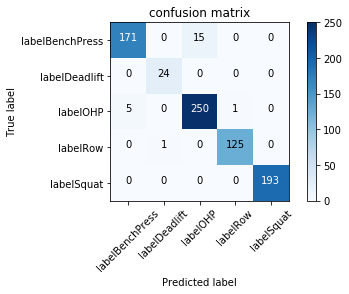

In [49]:
# Performance on the test data of the same weight class
test_cm = eval.confusion_matrix(test_y, class_test_y, class_train_prob_y.columns)
DataViz.plot_confusion_matrix(test_cm, class_train_prob_y.columns, normalize=False)

In [50]:
accuracy_score(test_y, class_test_y)

0.97197452229299364

In [51]:
# Prepare medium weight sets for testing
# For convience, we use the prepare.split_single_dataset_classification again
# but use 95% for the test split
m_train_X, m_test_X, m_train_y, m_test_y = prepare.split_single_dataset_classification(dataset_medium, ['label'], 'like', 0.05, filter=True, temporal=False)

In [52]:
# Make predictions on the the other weight class using the trained model
pred_prob_training_y = model.predict_proba(m_train_X[selected_features])
pred_prob_test_y = model.predict_proba(m_test_X[selected_features])
pred_training_y = model.predict(m_train_X[selected_features])
pred_test_y = model.predict(m_test_X[selected_features])
frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=model.classes_)
frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=model.classes_)

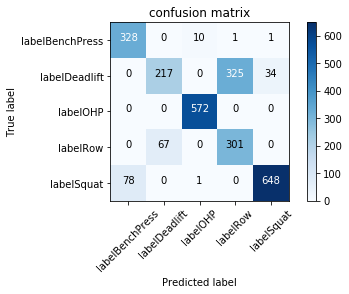

In [53]:
# Performance on the data of the other weight class
test_cm = eval.confusion_matrix(m_test_y, pred_test_y, frame_prob_training_y.columns)
DataViz.plot_confusion_matrix(test_cm, frame_prob_training_y.columns, normalize=False)

In [54]:
accuracy_score(m_test_y, pred_test_y)

0.799845141308556